In [4]:
from src.agents import generate_agents, neighborhood_lists
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # to remove 1e6 base from the x axis on plots

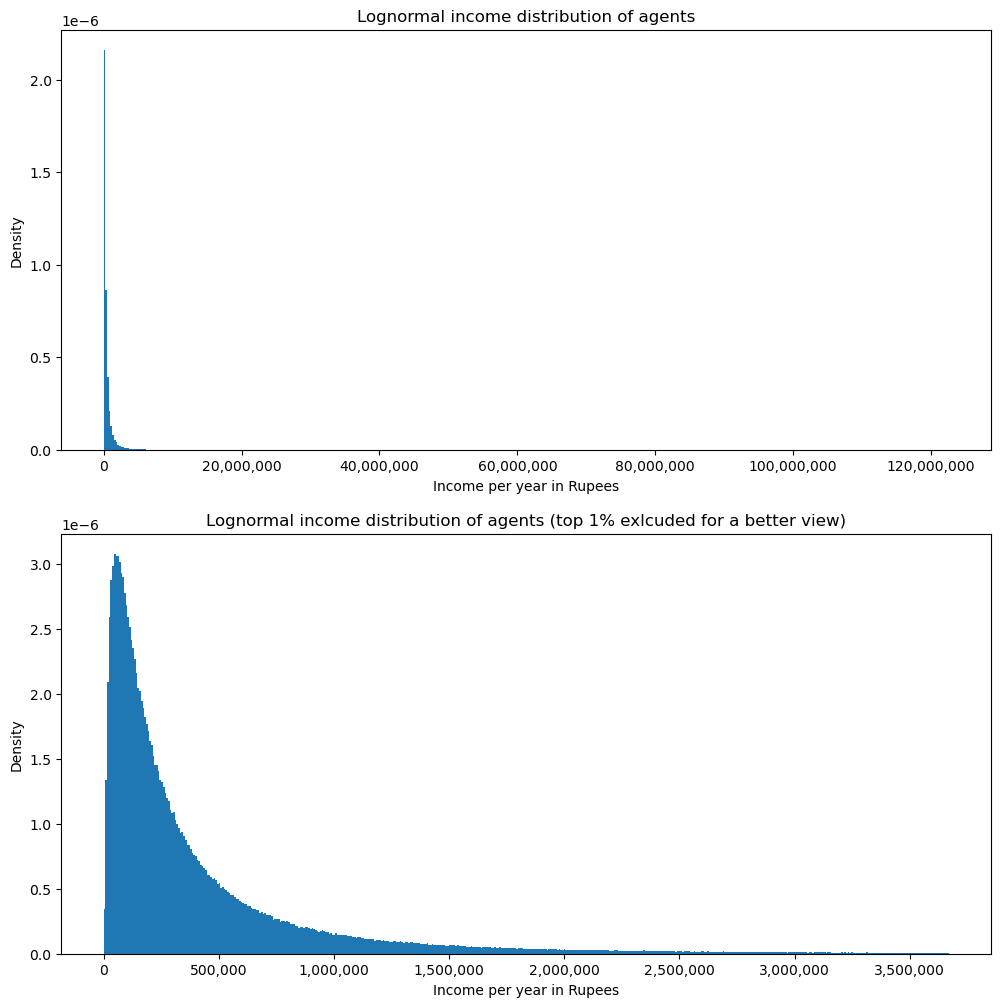

In [5]:
# plot the lognormal agents income distribution

n = 1_000_000
incomes, brackets, locations, neighborhoods = generate_agents(n)

# Cut off at, say, the 99.99th percentile for visualization
cutoff = np.percentile(incomes, 99.0)
incomes_percentile = incomes[incomes <= cutoff]

fig, axes = plt.subplots(2,1,figsize = (12,12)) # one plot for actual income distr, one with top 1% cut off
axes[0].hist(incomes, bins = 500, density = True)
axes[0].set_title("Lognormal income distribution of agents")
axes[0].set_xlabel("Income per year in Rupees")
axes[0].set_ylabel("Density")
# format x-axis numbers with commas
axes[0].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# with top 1% cut off
axes[1].hist(incomes_percentile, bins = 500, density = True)
axes[1].set_title("Lognormal income distribution of agents (top 1% exlcuded for a better view)")
axes[1].set_xlabel("Income per year in Rupees")
axes[1].set_ylabel("Density")
axes[1].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [7]:
print(neighborhood_lists(neighborhoods))

neighborhood = neighborhood_lists(neighborhoods)
print(len(neighborhood))

[array([   198,    281,    296, ..., 999384, 999634, 999659]), array([   129,    201,    228, ..., 999493, 999541, 999921]), array([    67,    123,    435, ..., 999288, 999570, 999947]), array([   175,    352,    812, ..., 999833, 999859, 999937]), array([     2,    454,    455, ..., 999915, 999916, 999993]), array([    76,     79,     96, ..., 999516, 999548, 999563]), array([    23,     88,    158, ..., 999721, 999828, 999957]), array([   239,    338,    405, ..., 999763, 999837, 999980]), array([     0,    286,    332, ..., 999832, 999882, 999977]), array([   172,    211,    472, ..., 999328, 999573, 999740]), array([    12,    159,    279, ..., 999769, 999878, 999970]), array([   131,    210,    244, ..., 999836, 999849, 999930]), array([    15,    111,    164, ..., 999768, 999933, 999963]), array([    27,    112,    160, ..., 999708, 999811, 999955]), array([    41,    207,    277, ..., 999524, 999584, 999899]), array([    92,    302,    347, ..., 999610, 999776, 999911]), array([